In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [3]:
df = pd.concat([df_train_obs_A,df_train_est_A])
df = df.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [4]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
df_nandrop = df
df_nandrop = df_nandrop.drop(columns= ['snow_densitykgm3'],axis = 1)
df_nandrop = df_nandrop.dropna()

df_nan0 = df.fillna(0)
df_nanmedian = df.fillna(df.median())
df_rolling2 = df.fillna(df.rolling(2).mean())

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Imputa i valori mancanti
df_knn =pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

In [7]:
df_dict = {
    'drop' : df_nandrop,
    'zero' : df_nan0,
    'median' : df_nanmedian,
    'knn' : df_knn,
    'rolling2' : df_rolling2,
}

In [8]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3
# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

In [9]:
import lightgbm as lgb
param = {'verbose' :-1}

model = lgb.LGBMRegressor(**param)

In [10]:
def test(df_dict):
    mean_mae_list = []
    for key in df_dict:
        print(key)
        data = df_dict[key]
        maelist = []
        for train_index, test_index in tscv.split(data):
            train_data = data.iloc[train_index]
            test_data = data.iloc[test_index]

            # Extract target variable for training and testing data
            y_train = train_data['pv_measurement']
            y_test = test_data['pv_measurement']

            # Extract features for training and testing data
            X_train = train_data.drop(columns = 'pv_measurement')
            X_test = test_data.drop(columns = 'pv_measurement')

            # Train the XGBoost model
            model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

            # Make predictions on the test data
            y_pred = model.predict(X_test)

            # Evaluate the model using Mean Absolute Error (MAE)
            mae = mean_absolute_error(y_test, y_pred)
            print("Mean Absolute Error:", mae)
            maelist.append(mae)
        # Return MAE
        mean_mae = np.average(maelist,weights=[1,2,3])
        print("Mean MAE: ",mean_mae )
        mean_mae_list.append(mean_mae)
    return mean_mae_list

In [11]:
test(df_dict)

drop
Mean Absolute Error: 243.60612056525966
Mean Absolute Error: 205.26797439820447
Mean Absolute Error: 191.66291954886827
Mean MAE:  204.85513800137892
zero
Mean Absolute Error: 224.97592067579524
Mean Absolute Error: 200.71542122835228
Mean Absolute Error: 194.37340234648647
Mean MAE:  201.5878283619932
median
Mean Absolute Error: 226.04145522432125
Mean Absolute Error: 200.4419415696115
Mean Absolute Error: 194.9832019709297
Mean MAE:  201.97915737938888
knn
Mean Absolute Error: 223.19331177215196
Mean Absolute Error: 198.97744281281123
Mean Absolute Error: 193.742298244397
Mean MAE:  200.39584868849423
rolling2
Mean Absolute Error: 226.060213393433
Mean Absolute Error: 198.99612725717907
Mean Absolute Error: 192.46365603252025
Mean MAE:  200.24057266755867


[204.85513800137892,
 201.5878283619932,
 201.97915737938888,
 200.39584868849423,
 200.24057266755867]

In [12]:
columns = df_knn.drop(columns = 'pv_measurement').columns


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Crea un oggetto MinMaxScaler
scaler = MinMaxScaler()

# Normalizza il DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_normalized['pv_measurement'] = df_knn[ 'pv_measurement']

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Crea un oggetto StandardScaler
scaler = StandardScaler()

# Standardizza il DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_scaled['pv_measurement'] = df_knn[ 'pv_measurement']

In [15]:
from sklearn.preprocessing import RobustScaler
# Crea un oggetto MinMaaxScaler
scaler = RobustScaler()
# Normalizza il DataFrame
df_robust = pd.DataFrame(scaler.fit_transform(df_knn[columns]),columns = df_knn[columns].columns, index = df_knn[columns].index)
df_robust['pv_measurement'] = df_knn['pv_measurement']

In [16]:
def z_score_standardization(data):
  mean = np.mean(data)
  std = np.std(data)
  standardized_data = (data - mean) / std
  return standardized_data

def z_score_standardization_dataframe(df):
    standardized_df = pd.DataFrame()
    for column in df.columns:
        standardized_df[column] = z_score_standardization(df[column])
    return standardized_df

# Esempio di utilizzo della funzione:

df_zscore = df_knn[columns]

df_zscore = z_score_standardization_dataframe(df_zscore)
df_zscore['pv_measurement'] = df_knn[ 'pv_measurement']

In [17]:
df_scaled_norm = {
    'norm' : df_normalized,
    'scaled' : df_scaled,
    'zscore' : df_zscore,
    'robust' : df_robust,
}

In [18]:
test(df_scaled_norm)

norm
Mean Absolute Error: 223.50929887634243
Mean Absolute Error: 199.5953904337968
Mean Absolute Error: 193.42414793757914
Mean MAE:  200.4954205927789
scaled
Mean Absolute Error: 227.4243481987587
Mean Absolute Error: 199.8460071525977
Mean Absolute Error: 193.68928151978648
Mean MAE:  201.36403451055227
zscore
Mean Absolute Error: 227.4243481987587
Mean Absolute Error: 199.8460071525977
Mean Absolute Error: 193.68928151978648
Mean MAE:  201.36403451055227
robust
Mean Absolute Error: 223.3557030863857
Mean Absolute Error: 199.26123455058885
Mean Absolute Error: 194.71831740311845
Mean MAE:  201.0055207328198


[200.4954205927789, 201.36403451055227, 201.36403451055227, 201.0055207328198]

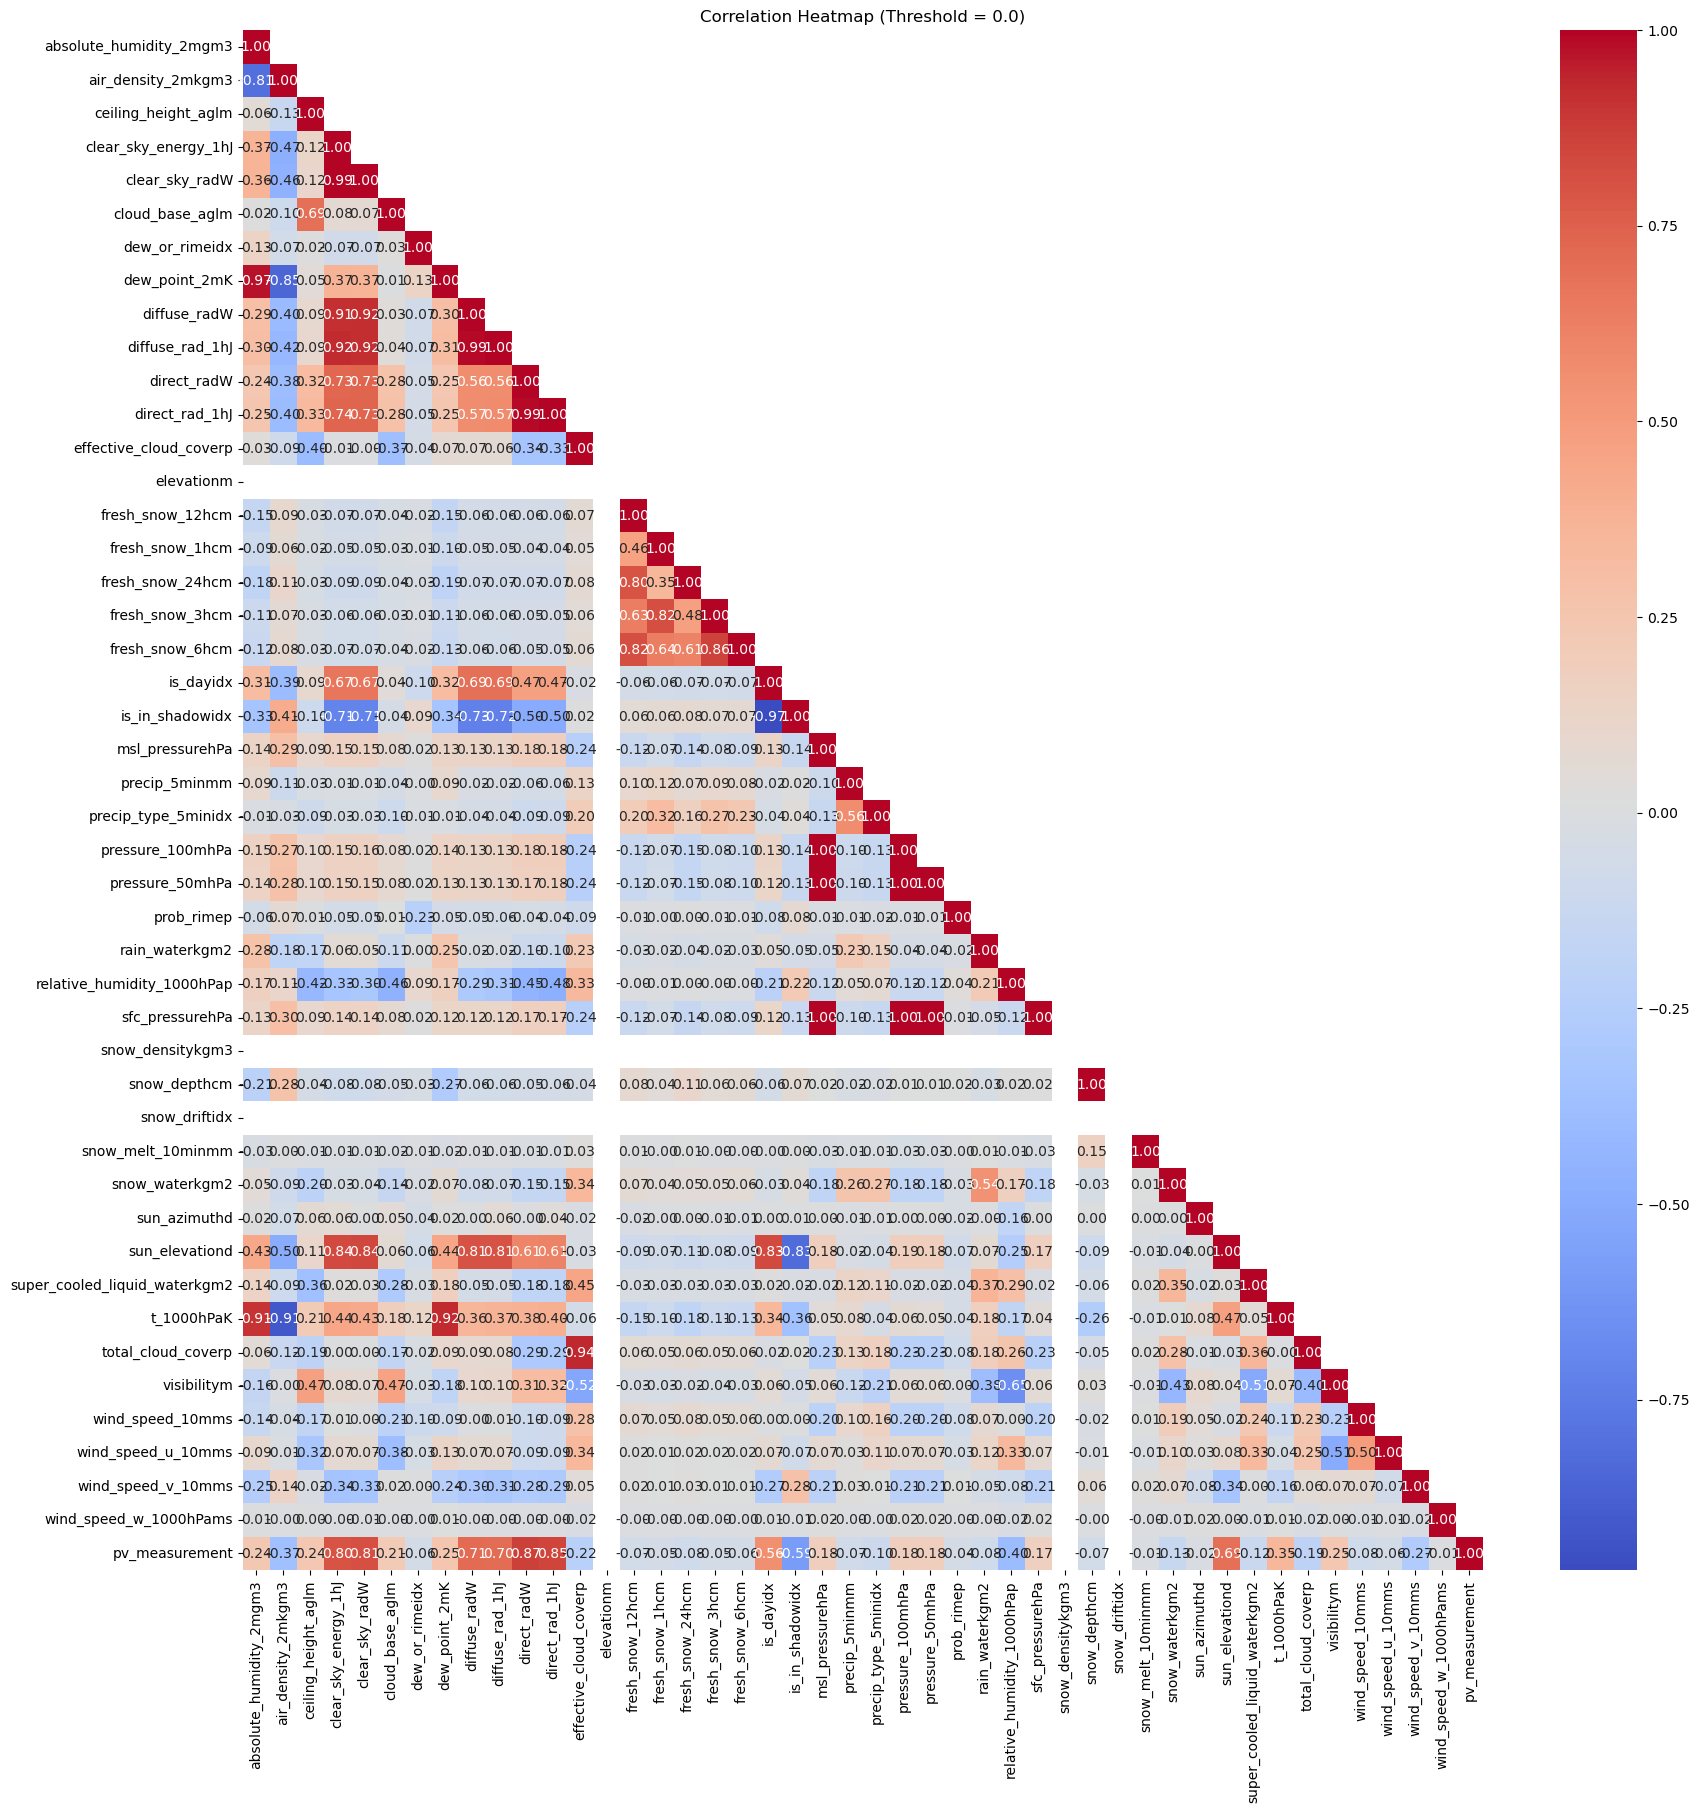

In [19]:
import seaborn as sns
# Calcola la matrice di correlazione
correlation_matrix = df_knn.corr()

# Definisci la soglia
threshold = 0.0

# Trova le colonne da mantenere
columns_to_keep = correlation_matrix.columns[(correlation_matrix >= threshold).sum() >=0]

# Seleziona solo le colonne che soddisfano il criterio
filtered_corr_matrix = correlation_matrix.loc[columns_to_keep, columns_to_keep]
mask_upper = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Crea una heatmap della matrice di correlazione filtrata
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask_upper)
plt.title(f'Correlation Heatmap (Threshold = {threshold})')
plt.show()


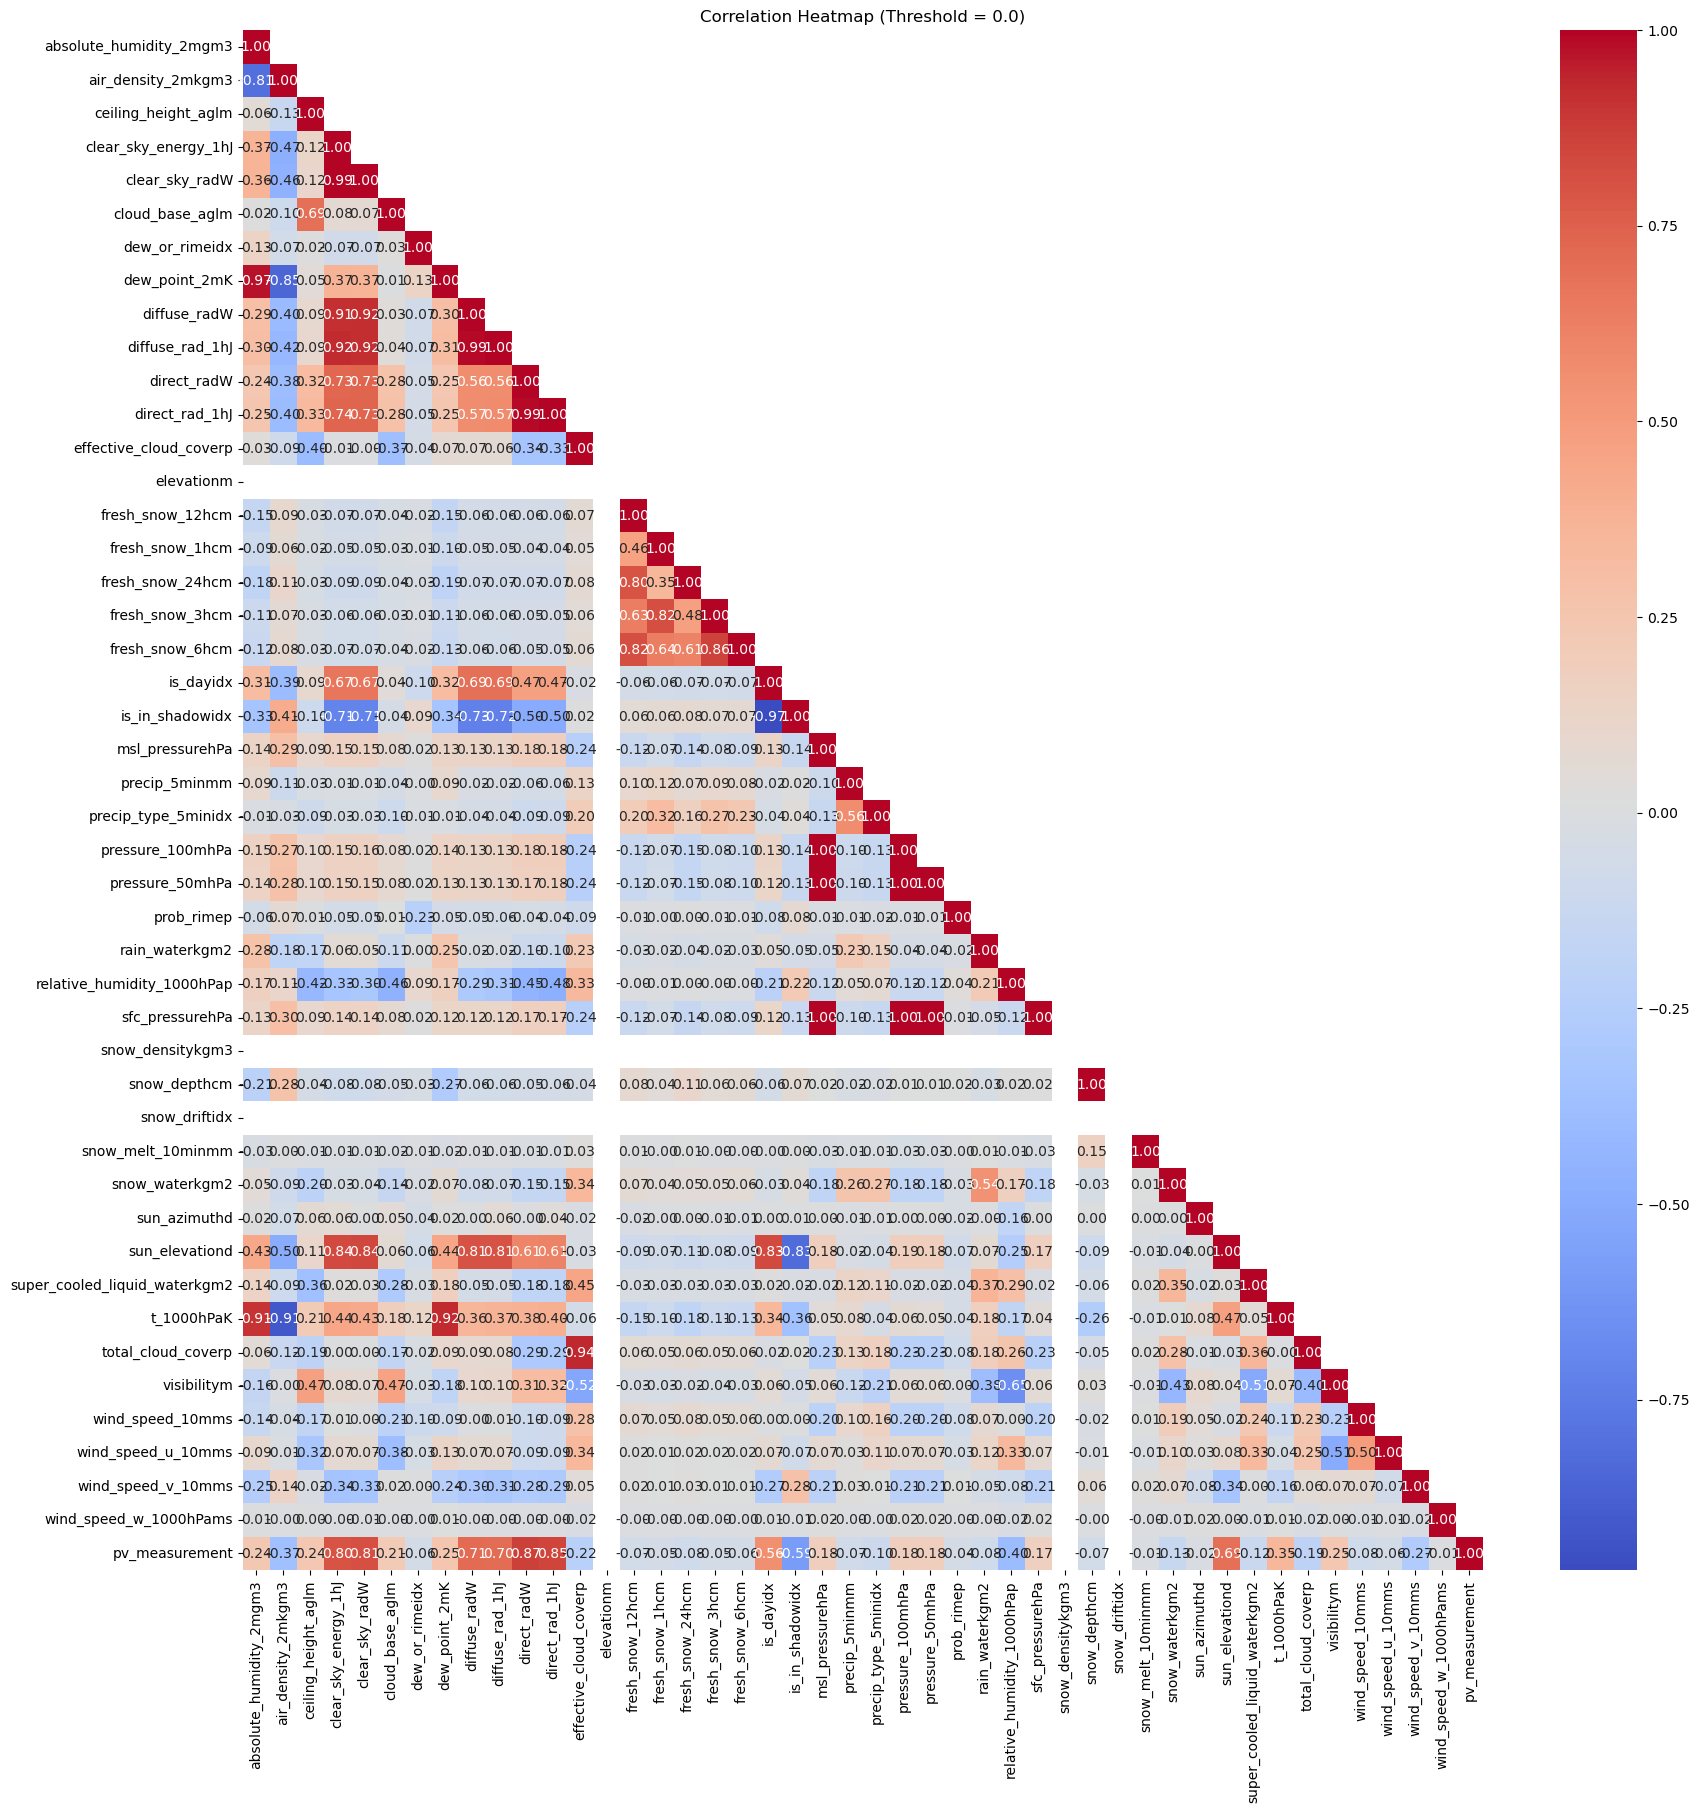

In [20]:
import seaborn as sns
# Calcola la matrice di correlazione
correlation_matrix = df_normalized.corr()

# Definisci la soglia
threshold = 0.0

# Trova le colonne da mantenere
columns_to_keep = correlation_matrix.columns[(correlation_matrix >= threshold).sum() >=0]

# Seleziona solo le colonne che soddisfano il criterio
filtered_corr_matrix = correlation_matrix.loc[columns_to_keep, columns_to_keep]
mask_upper = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Crea una heatmap della matrice di correlazione filtrata
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask_upper)
plt.title(f'Correlation Heatmap (Threshold = {threshold})')
plt.show()


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Carica i tuoi dati temporali in un DataFrame di pandas (assumendo che sia già caricato)
# Sostituisci 'your_time_series_data' con il nome della colonna dei dati temporali nel tuo DataFrame.
# Ad esempio, df['your_time_series_data'] rappresenta la serie temporale.
# df è il tuo DataFrame.

# Calcola l'autocorrelazione per un numero specifico di ritardi (es. 20 ritardi)
num_lags = 20
autocorrelation = y_diff.autocorr(lag=num_lags)

    # Crea il grafico dell'autocorrelazione
plot_acf(y_diff, lags=num_lags)
plt.title(col)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


NameError: name 'y_diff' is not defined

In [ ]:
y_diff = df['pv_measurement'] - df['pv_measurement'].shift(1)


In [ ]:
y_diff.plot()

In [ ]:
y_original = y_diff + df['pv_measurement'].shift(1)
y_original.plot()

In [22]:
df = df_knn

In [23]:
def outlier_detect_IQR(data,col,threshold=3):
    '''
    outlier detection by Interquartile Ranges Rule, also known as Tukey's test. 
    calculate the IQR ( 75th quantile - 25th quantile) 
    and the 25th 75th quantile. 
    Any value beyond:
        upper bound = 75th quantile + （IQR * threshold）
        lower bound = 25th quantile - （IQR * threshold）   
    are regarded as outliers. Default threshold is 3.
    '''
     
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.75) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.25) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
        percentage_of_outliers = (num_outliers / len(data)) * 100
        print(f'Percentage of outliers: {percentage_of_outliers:.2f}% relative to {len(data)} data points')
        print('————————————————————————————————————————————————————')
    return outlier_index, para

In [24]:
def outlier_detect_ZScore(data, col, threshold=3):
    '''
    Outlier detection by Z-Score method. 
    Calculate the Z-score for each data point.
    Any value beyond:
        upper bound = mean + (Z-score * threshold * standard deviation)
        lower bound = mean - (Z-score * threshold * standard deviation)   
    are regarded as outliers. Default threshold is 3.
    
    Parameters:
    - data: The pandas DataFrame containing the data.
    - col: The name of the column in the DataFrame to perform outlier detection on.
    - threshold: The Z-score threshold for defining outliers. Default is 3.
    
    Returns:
    - outlier_index: A boolean Series indicating which rows are outliers.
    - para: Tuple containing the upper and lower bounds for outliers.
    '''
    mean = data[col].mean()
    std = data[col].std()
    Upper_fence = mean + (threshold * std)
    Lower_fence = mean - (threshold * std)
    para = (Lower_fence, Upper_fence)
    z_scores = (data[col] - mean) / std
    outlier_index = (z_scores > threshold) | (z_scores < -threshold)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
        percentage_of_outliers = (num_outliers / len(data)) * 100
        print(f'Percentage of outliers: {percentage_of_outliers:.2f}% relative to {len(data)} data points')
        print('————————————————————————————————————————————————————')
    return outlier_index, para


In [25]:
for col in df.columns:
    outlier_index, para = outlier_detect_IQR(df,col)

Num of outliers detected: 6 in column absolute_humidity_2mgm3
Percentage of outliers: 0.02% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 172 in column air_density_2mkgm3
Percentage of outliers: 0.50% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 34 in column ceiling_height_aglm
Percentage of outliers: 0.10% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 1129 in column clear_sky_energy_1hJ
Percentage of outliers: 3.31% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 1078 in column clear_sky_radW
Percentage of outliers: 3.16% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 1905 in column cloud_base_aglm
Percentage of outliers: 5.59% relative to 34085 data points
————————————————————

In [26]:
for col in df.columns:
    outlier_index, para = outlier_detect_ZScore(df,col)


Num of outliers detected: 91 in column absolute_humidity_2mgm3
Percentage of outliers: 0.27% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 262 in column air_density_2mkgm3
Percentage of outliers: 0.77% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 127 in column ceiling_height_aglm
Percentage of outliers: 0.37% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 891 in column cloud_base_aglm
Percentage of outliers: 2.61% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 1194 in column dew_or_rimeidx
Percentage of outliers: 3.50% relative to 34085 data points
————————————————————————————————————————————————————
Num of outliers detected: 69 in column dew_point_2mK
Percentage of outliers: 0.20% relative to 34085 data points
————————————————————————————

In [27]:
df['pv_measurement'].quantile(0.90)

2381.28

In [28]:
df['pv_measurement'].max()

5733.42

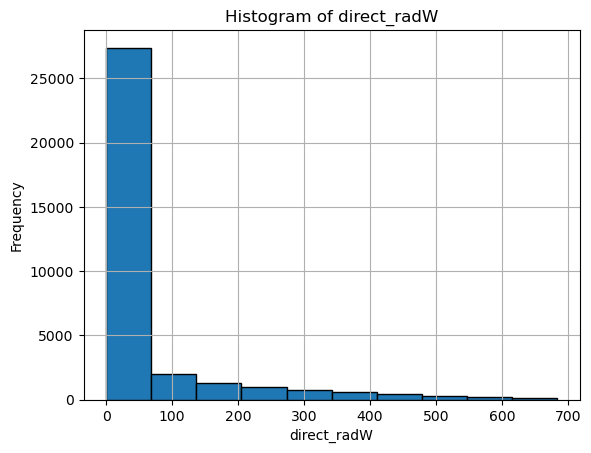

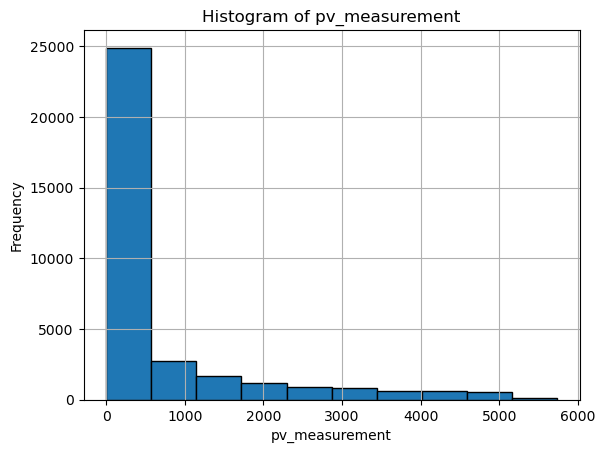

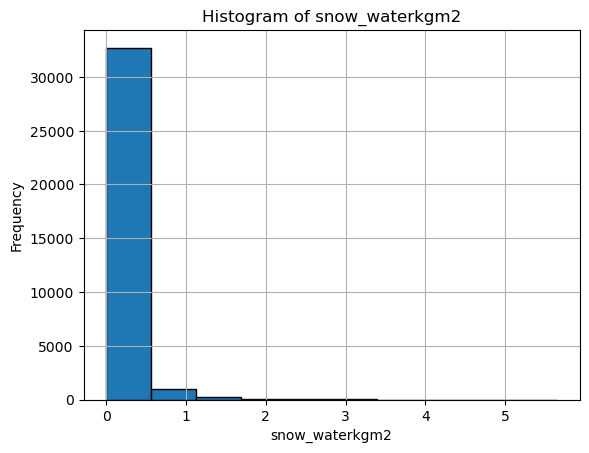

In [29]:
columns = ['direct_radW','pv_measurement','snow_waterkgm2',]
# Create histograms for each column
for column in columns:
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    plt.show()

<Axes: xlabel='date_forecast'>

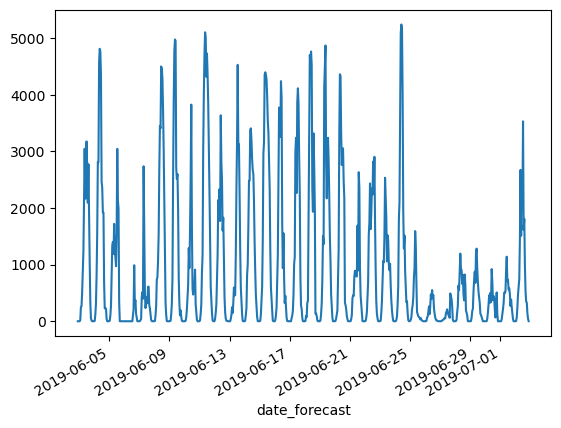

In [30]:
df['pv_measurement'][0:720].plot()


<Axes: xlabel='date_forecast'>

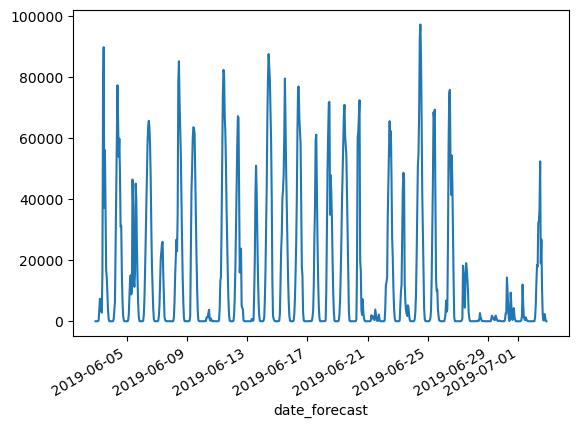

In [31]:
((df['direct_radW']*df['diffuse_radW']))[0:720].plot()

In [32]:
df_robust.index = pd.to_datetime(df_robust.index)

df_robust['hours'] = df_robust.index.hour
df = df_robust

<Axes: xlabel='date_forecast'>

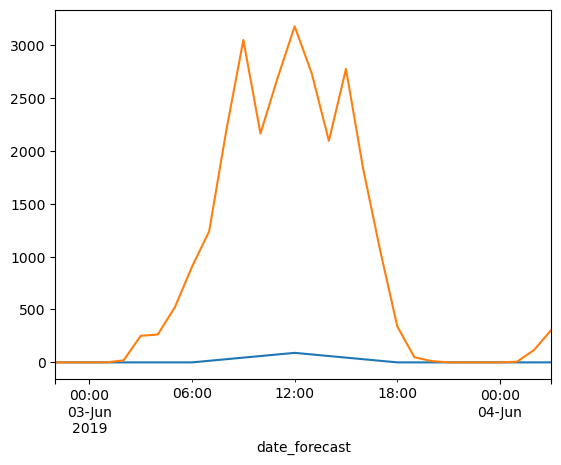

In [33]:
import pandas as pd
import math

# Function to calculate solar zenith angle
def calculate_solar_zenith(row):
    t = row['hours']
    Az = row['sun_azimuthd']
    
    # Calculate the solar zenith angle (θ) using a simplified model
    solar_zenith_angle = 90 - abs(t - 12) * (90 / 6)  # Assumes the sun is highest at noon
    
    # Ensure the solar zenith angle is between 0 and 90 degrees
    solar_zenith_angle = max(0, min(90, solar_zenith_angle))
    
    return solar_zenith_angle

# Apply the function to each row in the DataFrame
df['Solar Zenith Angle (degrees)'] = df.apply(calculate_solar_zenith, axis=1)

# Display the updated DataFrame
df['Solar Zenith Angle (degrees)'][0:30].plot()
df['pv_measurement'][0:30].plot()

<Axes: xlabel='date_forecast'>

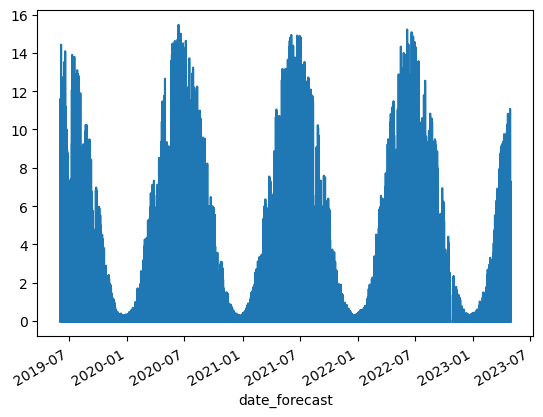

In [34]:
def calculate_total_radiation(row):
    DNI = row['direct_radW']
    solar_zenith_angle = row['Solar Zenith Angle (degrees)']
    DHI = row['diffuse_radW']
    # Calculate total solar radiation (G) using the formula
    G = DNI * math.cos(math.radians(solar_zenith_angle)) + DHI
    
    return G

# Apply the function to each row in the DataFrame
df['Total Solar Radiation (W/m²)'] = df.apply(calculate_total_radiation, axis=1)
df['Total Solar Radiation (W/m²)'].plot()

KeyError: 'hour_sin'

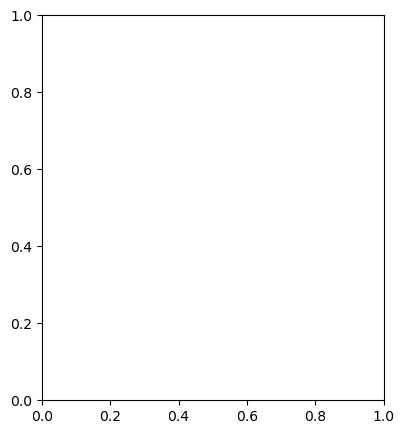

In [35]:
plt.figure(figsize=(15, 5))

# Plot 1: Solar Azimuth
plt.subplot(1, 3, 1)
plt.plot(df['Total Solar Radiation (W/m²)']*df['hour_sin'])
plt.xlabel('Total Solar Radiation (W/m²)')
plt.ylabel('RAD')
plt.title('Solar RAD')

# Plot 2: Solar Zenith Angle
plt.subplot(1, 3, 2)
plt.plot(df['direct_radW'])
plt.xlabel('Direct RAD')
plt.ylabel('RAD')
plt.title('DirectRAD')

# Plot 3: Total Solar Radiation
plt.subplot(1, 3, 3)
plt.plot(df['pv_measurement'])
plt.xlabel('pv')
plt.ylabel('pv')
plt.title('pv')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
df_robust = df
df_robust['month'] = df_robust.index.month

df_robust['hour_cos'] = np.cos(df_robust['hours'] * (2. * np.pi / 24))
df_robust['month_cos'] = np.cos(df_robust['month'] * (2. * np.pi / 12))
df_robust['hour_sin'] = np.sin(df_robust['hours'] * (2. * np.pi / 24))
df_robust['month_sin'] = np.sin(df_robust['month'] * (2. * np.pi / 12))

In [ ]:
df_test_A = pd.read_csv('X_test_A.csv')
df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})
df_test_A.set_index('date_forecast', inplace=True)
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)
df_test_A = df_test_A.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['hours'].head(50)

In [ ]:
X_test_estimated_a = pd.read_parquet('X_test_estimated.parquet')
X_test_estimated_a['direct_rad:W'].plot()

In [ ]:
df_reset = df_test_A.reset_index()

df_reset['sun_azimuthd'].plot()

In [36]:
import pandas as pd
import math

# Function to calculate solar zenith angle
def calculate_solar_zenith(row):
    t = row['hours']
    Az = row['sun_azimuthd']
    
    # Calculate the solar zenith angle (θ) using a simplified model
    solar_zenith_angle = 90 - abs(t - 12) * (90 / 6)  # Assumes the sun is highest at noon
    
    # Ensure the solar zenith angle is between 0 and 90 degrees
    solar_zenith_angle = max(0, min(90, solar_zenith_angle))
    
    return solar_zenith_angle

# Apply the function to each row in the DataFrame
df_reset['Solar Zenith Angle (degrees)'] = df_reset.apply(calculate_solar_zenith, axis=1)

# Display the updated DataFrame
df_reset['Solar Zenith Angle (degrees)'].plot()


NameError: name 'df_reset' is not defined

In [37]:
def calculate_total_radiation(row):
    DNI = row['direct_radW']
    solar_zenith_angle = row['Solar Zenith Angle (degrees)']
    DHI = row['diffuse_radW']
    # Calculate total solar radiation (G) using the formula
    G = DNI * math.cos(math.radians(solar_zenith_angle)) + DHI
    
    return G

# Apply the function to each row in the DataFrame
df_reset['Total Solar Radiation (W/m²)'] = df_reset.apply(calculate_total_radiation, axis=1)
df_reset['Total Solar Radiation (W/m²)'].plot()

NameError: name 'df_reset' is not defined

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

# Genera un dataset di esempio (sostituisci con i tuoi dati)
data = df_robust

# Definisci una lista di valori alpha e l1 da testare
alphas = [0.01, 0.1, 1.0, 0.02, 0.2, 0.05,0.5]
l1_ratios = [0.1, 0.5, 0.9, 0.2,0.3]

# Inizializza il TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Inizializza una lista per salvare i risultati (MAE)
results = []

for alpha in alphas:
    for l1_ratio in l1_ratios:
        mae_scores = []
        for train_index, test_index in tscv.split(X):
            train_data = data.iloc[train_index]
            test_data = data.iloc[test_index]

            # Split the data into features and target
            X_train = train_data.drop(columns = 'pv_measurement')
            y_train = train_data['pv_measurement']
            X_test = test_data.drop(columns = 'pv_measurement')
            y_test = test_data['pv_measurement']

            # Crea una pipeline con il RobustScaler e l'Elastic Net
            model = Pipeline([
                ('elastic_net', ElasticNet(alpha=alpha, l1_ratio=l1_ratio,max_iter=1000))
            ])

            # Addestra il modello
            model.fit(X_train, y_train)

            # Effettua previsioni
            y_pred = model.predict(X_test)

            # Calcola il MAE
            mae = mean_absolute_error(y_test, y_pred)
            mae_scores.append(mae)

        # Calcola il MAE medio per questa combinazione di alpha e l1_ratio
        avg_mae = np.mean(mae_scores)
        print('Avg_mae : ', avg_mae)
        results.append({
            'Alpha': alpha,
            'L1 Ratio': l1_ratio,
            'MAE': avg_mae
        })

# Converti i risultati in un DataFrame pandas per la visualizzazione
results_df = pd.DataFrame(results)
print(results_df)


NameError: name 'X' is not defined

In [39]:
results_df['MAE'].argmin()

NameError: name 'results_df' is not defined

In [40]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

# Genera un dataset di esempio
X, y = df_robust.drop(columns = 'pv_measurement'),df_robust['pv_measurement']

# Inizializza il modello Elastic Net
elastic_net = ElasticNet(alpha=0.2, l1_ratio=0.1)  # alpha controlla la forza della regolarizzazione

# Addestra il modello Elastic Net sui dati
elastic_net.fit(X, y)

# Ottieni i coefficienti delle feature selezionate
selected_features = elastic_net.coef_

# Crea un DataFrame per visualizzare le feature selezionate
selected_features_df = pd.DataFrame({'Feature Name': X.columns, 'Coefficient': selected_features})

# Stampa il DataFrame con le feature selezionate
print(selected_features_df)


                     Feature Name  Coefficient
0         absolute_humidity_2mgm3   -28.260156
1              air_density_2mkgm3    -6.581380
2             ceiling_height_aglm   -10.407485
3            clear_sky_energy_1hJ    62.889049
4                  clear_sky_radW   104.745901
5                 cloud_base_aglm    16.367349
6                  dew_or_rimeidx     0.515441
7                   dew_point_2mK     3.048140
8                    diffuse_radW   109.918866
9                 diffuse_rad_1hJ    68.489000
10                    direct_radW   181.793319
11                 direct_rad_1hJ    17.992472
12         effective_cloud_coverp    -5.740951
13                     elevationm     0.000000
14               fresh_snow_12hcm    -1.853078
15                fresh_snow_1hcm     1.371283
16               fresh_snow_24hcm    -9.839926
17                fresh_snow_3hcm     3.322997
18                fresh_snow_6hcm     3.239225
19                      is_dayidx     0.070639
20           

In [41]:
selected_features_df = pd.DataFrame({'Feature Name': df_robust.drop(columns = 'pv_measurement').columns, 'Coefficient': selected_features})
filtered_results_df = selected_features_df[selected_features_df['Coefficient'] > 0]
filtered_results_df['Feature Name'].tolist()

['clear_sky_energy_1hJ',
 'clear_sky_radW',
 'cloud_base_aglm',
 'dew_or_rimeidx',
 'dew_point_2mK',
 'diffuse_radW',
 'diffuse_rad_1hJ',
 'direct_radW',
 'direct_rad_1hJ',
 'fresh_snow_1hcm',
 'fresh_snow_3hcm',
 'fresh_snow_6hcm',
 'is_dayidx',
 'msl_pressurehPa',
 'pressure_100mhPa',
 'pressure_50mhPa',
 'relative_humidity_1000hPap',
 'sfc_pressurehPa',
 'sun_elevationd',
 'super_cooled_liquid_waterkgm2',
 'wind_speed_v_10mms',
 'Solar Zenith Angle (degrees)',
 'Total Solar Radiation (W/m²)']

In [42]:

df['dew_point_2mK'].min()

-2.480104438018782

<Axes: xlabel='date_forecast'>

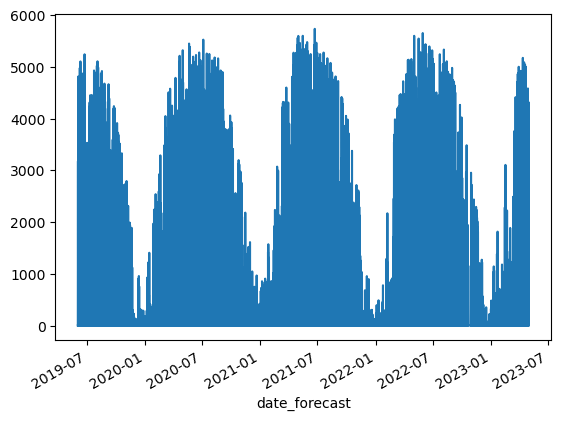

In [43]:
df['pv_measurement'].plot()

In [44]:
df_test_A.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

<Axes: xlabel='date_forecast'>

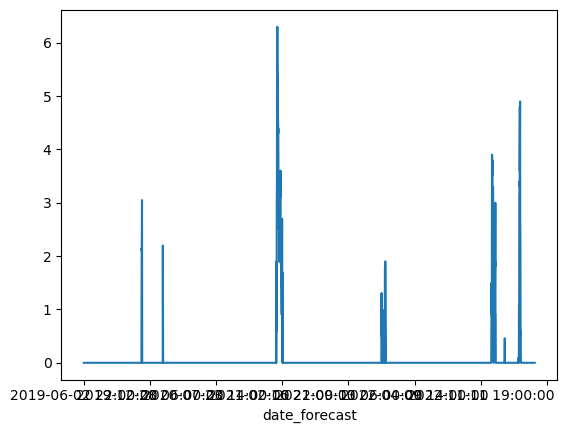

In [45]:
df_knn['snow_depthcm'].plot()

In [46]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

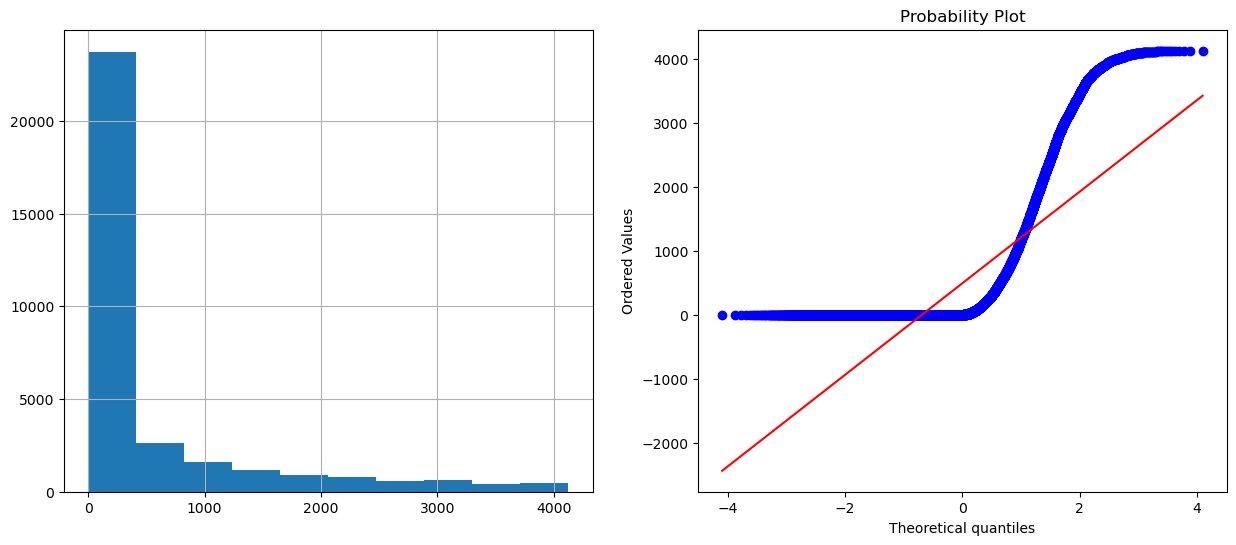

In [67]:
import scipy.stats as stats
diagnostic_plots(df_knn, 'pv_measurement')


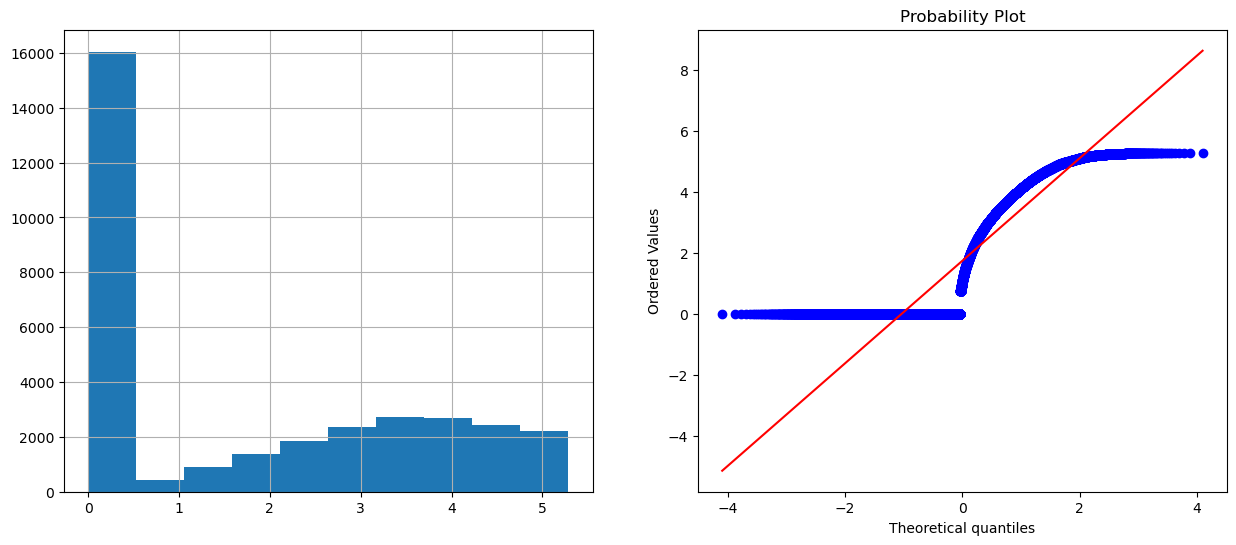

In [73]:
df_knn['Fare_boxcox'] = (df_knn['pv_measurement'])**(1/5) # you can vary the exponent as needed
diagnostic_plots(df_knn, 'Fare_boxcox')


In [69]:
df_knn = df_knn[~pd.Series(outlier_index)]
df_knn = df_knn.reset_index()

C:\Users\claxl\AppData\Local\Temp\ipykernel_31080\91006979.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_knn = df_knn[~pd.Series(outlier_index)]
C:\Users\claxl\AppData\Local\Temp\ipykernel_31080\91006979.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_knn = df_knn.reset_index()


In [74]:
df.tail()

,absolute_humidity_2mgm3,air_density_2mkgm3,ceiling_height_aglm,clear_sky_energy_1hJ,clear_sky_radW,cloud_base_aglm,dew_or_rimeidx,dew_point_2mK,diffuse_radW,diffuse_rad_1hJ,...,visibilitym,wind_speed_10mms,wind_speed_u_10mms,wind_speed_v_10mms,wind_speed_w_1000hPams,pv_measurement,hours,Solar Zenith Angle (degrees),Total Solar Radiation (W/m²),Fare_boxcox
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-04-30 19:00:00,-0.314815,0.502514,-0.195767,0.070595,0.002882,-0.417586,0.0,-0.355722,0.010970,0.157659,...,-0.397196,1.010309,1.091463,0.574468,0.0,9.02,19,0.0,0.013898,2.071171
2023-04-30 20:00:00,-0.327160,0.567840,-0.169917,-0.021582,-0.013915,-0.415352,0.0,-0.368160,-0.029016,-0.044935,...,-0.471513,0.793814,0.902439,0.734043,0.0,0.00,20,0.0,-0.029016,0.000000
2023-04-30 21:00:00,-0.327160,0.592966,-0.189187,-0.024129,-0.013915,-0.414174,0.0,-0.368160,-0.029016,-0.064924,...,-0.480800,0.711340,0.792683,0.861702,0.0,0.00,21,0.0,-0.029016,0.000000
2023-04-30 22:00:00,-0.327160,0.592966,-0.289785,-0.024129,-0.013915,-0.426600,0.0,-0.368160,-0.029016,-0.064924,...,-0.692134,0.567010,0.695122,0.840426,0.0,0.00,22,0.0,-0.029016,0.000000
2023-04-30 23:00:00,-0.327160,0.592966,-0.209724,-0.024129,-0.013915,-0.427355,0.0,-0.370648,-0.029016,-0.064924,...,-0.764946,0.422680,0.585366,0.840426,0.0,0.00,23,0.0,-0.029016,0.000000


In [78]:
df.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'pv_measurement', 

<Axes: xlabel='date_forecast'>

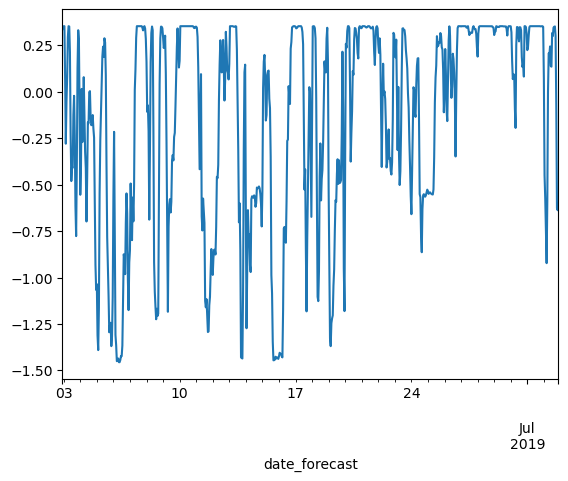

In [80]:
df['effective_cloud_coverp'][0:720].plot()